In [ ]:
%cd ..

In [2]:
from typing import List, Dict, Any, TypedDict, Annotated
from langgraph.graph.message import add_messages

# *** MODIFIED STATE ***
class MultiStepAgentState(TypedDict):
    messages: Annotated[list, add_messages]
    route: str = None # Keep for specialized agent routing *within* a step
    plan: List[str] = None # Stores the decomposed steps of the plan
    executed_steps: List[str] = None # Stores summaries of executed steps/results
    current_step_index: int = 0 # Tracks which step we are on
    original_query: str = None # Stores the initial complex query for final synthesis

In [3]:
# %% Import necessary libraries
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END, START

from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list, add_messages]
    route: str = None

# %% Setup LLM - Replace "llama3.3" with your desired model if needed
# Ensure Ollama server is running if using ChatOllama
temperature = 0.9
llm = ChatOllama(model="llama3.3", temperature=temperature)

# %% Define Placeholder Tools
# Normally, these would have real implementations and potentially Pydantic schemas for args
from tumkwe_invest.news import (
	tools as news_tools,
	TOOL_DESCRIPTION as NEWS_TOOL_DESCRIPTION,
)
from tumkwe_invest.sector import (
	tools as sector_tools,
	TOOL_DESCRIPTION as SECTOR_TOOL_DESCRIPTION,
)
from tumkwe_invest.ticker import (
	tools as ticker_tools,
	TOOL_DESCRIPTION as TICKER_TOOL_DESCRIPTION,
)

# from tumkwe_invest import tools as all_tools

In [4]:
# %% Create Specialized LLM Bindings
# Each LLM instance is bound only to the tools relevant for its role

llm_router = llm  # Router doesn't need tools bound for *this* simple routing logic
llm_news = llm.bind_tools(tools=news_tools)
llm_sector = llm.bind_tools(tools=sector_tools)
llm_ticker = llm.bind_tools(tools=ticker_tools)

In [5]:
PLANNER_PROMPT = """You are an expert planner. Your task is to analyze the user's query and determine if it requires multiple steps involving different capabilities (news, sector analysis, ticker information) or if it can be handled by a single agent directly.

Available agents and their capabilities:
- 'news_agent': {NEWS_TOOL_DESCRIPTION}
- 'sector_agent': {SECTOR_TOOL_DESCRIPTION}
- 'ticker_agent': {TICKER_TOOL_DESCRIPTION}

User Query: {query}

Analysis Steps:
1. Identify the core goals of the user query.
2. Determine if achieving these goals requires information from different domains (news, sector, ticker).
3. If it's a simple query solvable by one agent type, respond ONLY with:
   SIMPLE: [agent_keyword]
   (e.g., SIMPLE: news / SIMPLE: sector / SIMPLE: ticker / SIMPLE: general)
4. If it requires multiple steps, break it down into a sequence of single-focus sub-tasks. Each sub-task should clearly state what needs to be done and map roughly to one agent's capability. Respond ONLY with a numbered plan, like this:
   PLAN:
   1. [First sub-task (e.g., Find recent news about company X)]
   2. [Second sub-task (e.g., Get stock price for company X)]
   3. [Third sub-task (e.g., Analyze the sector trends for company X's industry)]
   ...

Provide ONLY the SIMPLE response or the PLAN response.
"""

def plan_request(state: MultiStepAgentState):
    print("--- Calling Planner Agent ---")
    query = state["messages"][-1].content
    prompt = PLANNER_PROMPT.format(
        query=query,
        NEWS_TOOL_DESCRIPTION=NEWS_TOOL_DESCRIPTION.strip(),
        SECTOR_TOOL_DESCRIPTION=SECTOR_TOOL_DESCRIPTION.strip(),
        TICKER_TOOL_DESCRIPTION=TICKER_TOOL_DESCRIPTION.strip(),
    )
    # Using a separate LLM instance for planning might be beneficial if using different settings/prompts
    planner_llm = llm # Or initialize a dedicated ChatOllama instance
    response = planner_llm.invoke([HumanMessage(content=prompt)])
    print(f"Planner Output:\n{response.content}")

    if response.content.startswith("SIMPLE:"):
        route = response.content.split(":", 1)[1].strip().lower()
        return {"route": route, "plan": None, "original_query": query} # Route directly
    elif response.content.startswith("PLAN:"):
        plan_str = response.content.split("PLAN:", 1)[1].strip()
        plan_steps = [step.strip() for step in plan_str.split('\n') if step.strip() and step.strip()[0].isdigit()]
        return {
            "plan": plan_steps,
            "current_step_index": 0,
            "executed_steps": [],
            "route": None, # Clear route as we are following plan
            "original_query": query
        }
    else:
        # Fallback: treat as simple general query if planner fails
        print("Planner failed to provide valid output, routing to general.")
        return {"route": "general", "plan": None, "original_query": query}

In [6]:
# Re-purpose the ROUTER_PROMPT slightly for the executor
EXECUTOR_ROUTER_PROMPT = """You are an expert step executor router. Your task is to analyze the CURRENT STEP of a plan and determine which specialized agent is best suited to handle it.

Available agents:
- 'news_agent': {NEWS_TOOL_DESCRIPTION}
- 'sector_agent': {SECTOR_TOOL_DESCRIPTION}
- 'ticker_agent': {TICKER_TOOL_DESCRIPTION}
- 'general_agent': Handles general information gathering or steps not fitting others.

Based *only* on the CURRENT STEP provided below, respond with *only* one of the following exact keywords: 'news', 'sector', 'ticker', or 'general'.

CURRENT STEP:
{step_description}
"""

def execute_step(state: MultiStepAgentState):
    print("--- Calling Executor Agent ---")
    plan = state["plan"]
    step_index = state["current_step_index"]

    if plan is None or step_index >= len(plan):
        print("Error: Execute step called with no plan or index out of bounds.")
        return {"route": "general"} # Or handle error differently

    current_step_description = plan[step_index]
    print(f"Executing Step {step_index + 1}: {current_step_description}")

    prompt = EXECUTOR_ROUTER_PROMPT.format(
        step_description=current_step_description,
        NEWS_TOOL_DESCRIPTION=NEWS_TOOL_DESCRIPTION.strip(),
        SECTOR_TOOL_DESCRIPTION=SECTOR_TOOL_DESCRIPTION.strip(),
        TICKER_TOOL_DESCRIPTION=TICKER_TOOL_DESCRIPTION.strip(),
    )
    response = llm_router.invoke([HumanMessage(content=prompt)])
    route = response.content.strip().lower()
    print(f"Executor Routing Decision: {route} for step '{current_step_description}'")

    # We need to make sure the specialized agent knows *what* specific sub-task to perform.
    # We'll pass the current step description along implicitly via the state messages,
    # perhaps by adding a message before calling the specialized agent.
    # Or modify the specialized agent call slightly. Let's try adding a message.
    step_message = HumanMessage(content=f"Focus on this task: {current_step_description}")

    return {
        "route": route,
        "messages": [step_message] # Add the specific step instruction to message history
    }

In [7]:
SYNTHESIS_PROMPT = """You are a final response synthesizer.
The user's original query was: {original_query}

The following steps were executed with their results:
{executed_steps_summary}

Synthesize a comprehensive final answer to the original query based on the results of the executed steps. Be coherent and address all parts of the original request.
"""

def process_step_result(state: MultiStepAgentState):
    print("--- Processing Step Result ---")
    last_message = state["messages"][-1]
    step_index = state["current_step_index"]
    plan = state["plan"]
    executed_steps = state["executed_steps"] or [] # Initialize if None

    # Store result (could be more sophisticated, e.g., storing tool outputs directly)
    step_summary = f"Step {step_index + 1} ({plan[step_index]}): {last_message.content}"
    executed_steps.append(step_summary)

    next_step_index = step_index + 1

    if next_step_index < len(plan):
        # Move to the next step
        print(f"Finished step {step_index + 1}. Moving to step {next_step_index + 1}.")
        return {
            "executed_steps": executed_steps,
            "current_step_index": next_step_index,
            "route": None # Reset route, executor will set it for next step
        }
    else:
        # Plan finished, synthesize final answer
        print("Plan finished. Synthesizing final answer.")
        summary_str = "\n".join(executed_steps)
        synthesis_prompt_filled = SYNTHESIS_PROMPT.format(
            original_query=state["original_query"],
            executed_steps_summary=summary_str
        )
        # Use a capable LLM for synthesis
        synthesis_llm = llm # Or a dedicated instance
        final_response = synthesis_llm.invoke([HumanMessage(content=synthesis_prompt_filled)])
        print("--- Final Synthesized Response ---")
        return {
            "executed_steps": executed_steps, # Keep history
            "messages": [final_response], # Add final answer
            "plan": None # Clear plan
        }

In [8]:
llm_news

RunnableBinding(bound=ChatOllama(model='llama3.3', temperature=0.9), kwargs={'tools': [{'type': 'function', 'function': {'name': 'fetch_company_news', 'description': 'Fetch news articles about a specific company.\n\nArgs:\n    ticker: Stock ticker symbol or company name for search. Works perfectly with ticker symbol\n    max_articles: Maximum number of articles to retrieve\n\nReturns:\n    List news', 'parameters': {'properties': {'ticker': {'type': 'string'}, 'max_articles': {'default': 10, 'type': 'integer'}}, 'required': ['ticker'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [9]:
# %% Define Agent Nodes

# 1. Router Agent: Decides which specialist agent to call
ROUTER_PROMPT = """You are an expert request router. Your task is to analyze the user's latest query and determine which specialized agent is best suited to handle it.
The available agents are:
- 'news_agent': {NEWS_TOOL_DESCRIPTION}
- 'sector_agent': {SECTOR_TOOL_DESCRIPTION}
- 'ticker_agent': {TICKER_TOOL_DESCRIPTION}
- 'general_agent': Handles general conversation, greetings, or queries not fitting the other categories.

Based *only* on the user's last message, respond with *only* one of the following exact keywords: 'news', 'sector', 'ticker', or 'general'.

User Query:
{query}
"""

In [10]:
def route_request(state: MessagesState):
    messages = state["messages"]
    user_query = messages[-1].content
    # Use a dedicated prompt for routing
    router_messages = [
        HumanMessage(
            content=ROUTER_PROMPT.format(
                query=user_query,
                NEWS_TOOL_DESCRIPTION=NEWS_TOOL_DESCRIPTION.strip(),
                SECTOR_TOOL_DESCRIPTION=SECTOR_TOOL_DESCRIPTION.strip(),
                TICKER_TOOL_DESCRIPTION=TICKER_TOOL_DESCRIPTION.strip(),
            )
        ),
    ]
    print("--- Calling Router Agent ---")
    response = llm_router.invoke(router_messages)
    print(f"Router Decision: {response.content}")
    return {
        "messages": [], "route": response.content
    }  # The content itself is the routing decision


# 2. Specialized Agent Nodes: Handle tasks for their category
def call_news_agent(state: MessagesState):
    messages = state["messages"]
    # Filter messages or add context if needed
    print("--- Calling News Agent ---")
    response = llm_news.invoke(messages)
    return {"messages": [response]}


def call_sector_agent(state: MessagesState):
    messages = state["messages"]
    print("--- Calling Sector Agent ---")
    response = llm_sector.invoke(messages)
    return {"messages": [response]}


def call_ticker_agent(state: MessagesState):
    messages = state["messages"]
    print("--- Calling Ticker Agent ---")
    response = llm_ticker.invoke(messages)
    return {"messages": [response]}


def call_general_agent(state: MessagesState):
    messages = state["messages"]
    print("--- Calling General Agent ---")
    # This agent might not have tools, or different general tools
    response = llm.invoke(messages)  # Using the base LLM
    return {"messages": [response]}

In [11]:
# %% Define Tool Nodes
# Each ToolNode handles tools for its specific category
news_tool_node = ToolNode(news_tools)
sector_tool_node = ToolNode(sector_tools)
ticker_tool_node = ToolNode(ticker_tools)

# %% Define Conditional Edge Logic

# 1. Decide branch after router
def decide_next_node(state: MessagesState):
	route: str = state["route"]
	# Check the content of the last message (which is the router's decision)
	if route is not None:
		content = route.strip().lower()
		if "news" in content:
			return "news_agent"
		elif "sector" in content:
			return "sector_agent"
		elif "ticker" in content:
			return "ticker_agent"
		else:
			return "general_agent" # Default to general if no keyword match
	return END # Should not happen in this setup ideally

# 2. Decide if a specialist agent needs to call its tools
def route_tools(state: MessagesState) -> str:
	"""
	Use in the conditional_edge to route to the ToolNode if the last message
	has tool calls. Otherwise, route to the end.
	"""
	messages = state["messages"]
	last_message = messages[-1]
	if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
		# LangGraph needs the ToolMessage invocation to be associated with the AI message Tool Call ID
		# The ToolNode will handle appending the ToolMessage with the results automatically
		print(f"--- Routing to Tools: {last_message.tool_calls[0]['name']} ---")
		return "call_tools" # A generic name for the routing decision
	print("--- No Tool Call Detected by Agent ---")
	return END

In [12]:
# Define New State
# class MultiStepAgentState(TypedDict): ... (as defined above)

# Build the Graph using the new state
workflow = StateGraph(MultiStepAgentState)

# Add New Nodes
workflow.add_node("planner", plan_request)
workflow.add_node("executor", execute_step)
workflow.add_node("step_processor", process_step_result)

# Add Existing Nodes (Ensure they accept MultiStepAgentState if type hints are strict)
# Note: Your existing agent/tool nodes might need slight adjustments if they
# rely *only* on MessagesState structure. Usually, accessing state['messages'] works fine.
workflow.add_node("news_agent", call_news_agent)
workflow.add_node("news_tools", news_tool_node)
workflow.add_node("sector_agent", call_sector_agent)
workflow.add_node("sector_tools", sector_tool_node)
workflow.add_node("ticker_agent", call_ticker_agent)
workflow.add_node("ticker_tools", ticker_tool_node)
workflow.add_node("general_agent", call_general_agent)


# Define Conditional Edge Logic

# 1. After Planner: Decide if simple route or start plan execution
def decide_plan_or_route(state: MultiStepAgentState):
    if state.get("plan") and len(state["plan"]) > 0:
        return "execute_plan" # Start multi-step execution
    elif state.get("route"):
        return "route_simple" # Handle simple, single-agent task
    else:
        print("Error: Planner did not produce plan or simple route.")
        return END # Or route to general agent as fallback

# 2. Decide branch after Executor routes a step (existing logic, renamed for clarity)
def route_to_specialist(state: MultiStepAgentState):
    route = state.get("route")
    if route:
        content = route.strip().lower()
        if "news" in content: return "news_agent"
        if "sector" in content: return "sector_agent"
        if "ticker" in content: return "ticker_agent"
        return "general_agent"
    print("Error: No route found after executor.")
    return END # Fallback

# 3. Decide if a specialist agent needs tools (existing logic)
# def route_tools(state: MultiStepAgentState) -> str: ... (Keep as is, check last message tool_calls)

# 4. After processing a step result: Decide if plan continues or ends
def decide_continue_or_synthesize(state: MultiStepAgentState):
    if state.get("plan") is None: # Plan was cleared by step_processor upon completion
        return END # Final synthesis happened in step_processor
    else:
        return "continue_plan" # Go execute the next step

# Define Graph Edges
workflow.add_edge(START, "planner")

# Conditional edge after planner
workflow.add_conditional_edges(
    "planner",
    decide_plan_or_route,
    {
        "execute_plan": "executor", # Start plan execution loop
        "route_simple": "executor", # If simple, reuse executor logic to route once
        END: END
    }
)

# Executor routes to the correct specialist based on 'route' state
workflow.add_conditional_edges(
    "executor",
    route_to_specialist,
    {
        "news_agent": "news_agent",
        "sector_agent": "sector_agent",
        "ticker_agent": "ticker_agent",
        "general_agent": "general_agent",
        END: END
    }
)

# --- Specialist Agent Branches ---
# News Branch
workflow.add_conditional_edges("news_agent", route_tools, {"call_tools": "news_tools", END: "step_processor"})
workflow.add_edge("news_tools", "step_processor") # After tool use, process result

# Sector Branch
workflow.add_conditional_edges("sector_agent", route_tools, {"call_tools": "sector_tools", END: "step_processor"})
workflow.add_edge("sector_tools", "step_processor")

# Ticker Branch
workflow.add_conditional_edges("ticker_agent", route_tools, {"call_tools": "ticker_tools", END: "step_processor"})
workflow.add_edge("ticker_tools", "step_processor")

# General Branch (If it completes a step, it should also go to processor)
workflow.add_edge("general_agent", "step_processor") # Assuming general agent completes a step


# --- Plan Continuation Loop ---
workflow.add_conditional_edges(
    "step_processor",
    decide_continue_or_synthesize,
    {
        "continue_plan": "executor", # Loop back to execute next step
        END: END # Final response generated in step_processor
    }
)

# Compile
memory = MemorySaver() # Make sure memory saver is compatible if state changes drastically
graph = workflow.compile(checkpointer=memory)

# Visualization and Interaction Loop remain similar, just use MultiStepAgentState

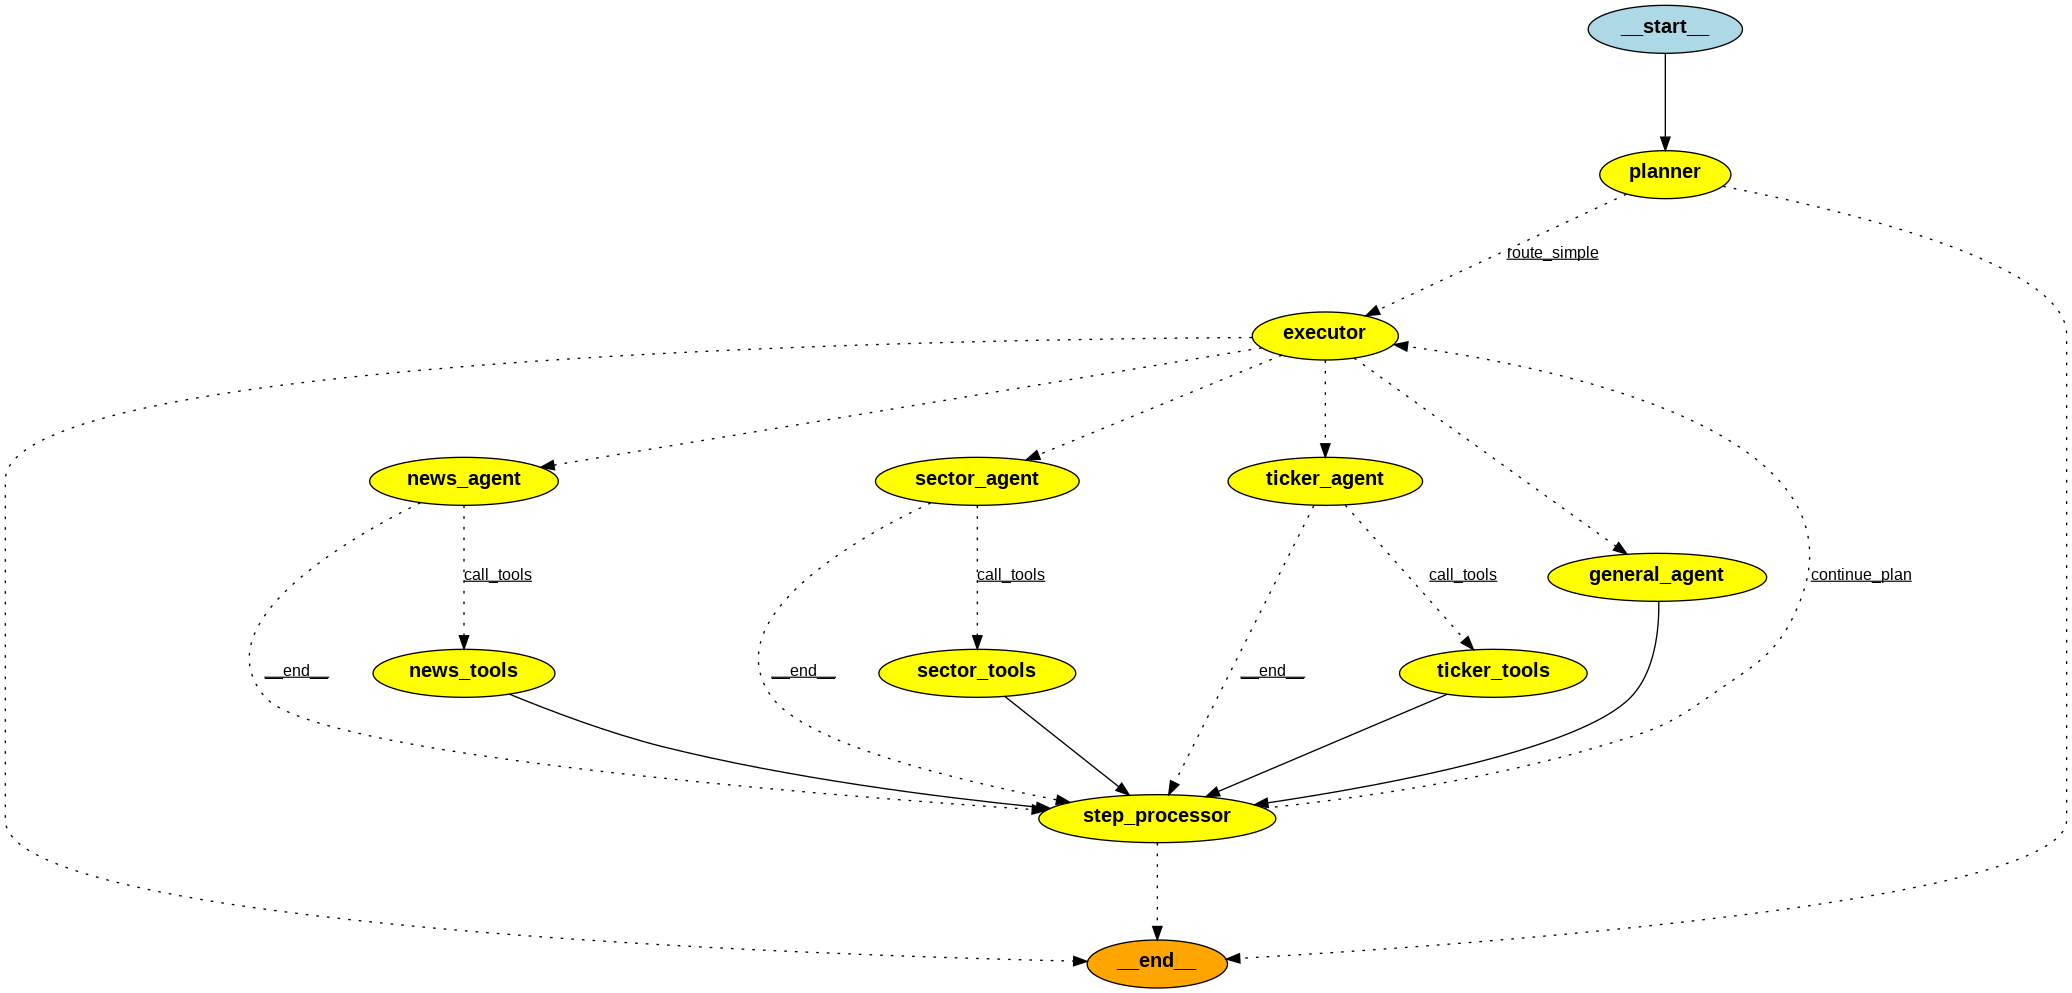

In [13]:
# %% Visualize the Graph (Optional)
try:
	img_data = graph.get_graph().draw_png()
	display(Image(img_data))
except Exception as e:
	# This requires some extra dependencies (like graphviz) and is optional
	print(f"Graph visualization failed (requires graphviz): {e}")
	pass

In [14]:
# %% Interaction Loop
config = {"configurable": {"thread_id": "user-thread-1"}} # Use a unique ID for conversation history

def stream_graph_updates(user_input: str, config: dict):
	"""Helper function to stream graph events and print messages."""
	try:
		# The input is a list of messages, which is the format MessagesState expects
		inputs = {"messages": [HumanMessage(content=user_input)]}
		for event in graph.stream(inputs, config, stream_mode="values"):
			# The 'messages' key holds the list of messages in the state
			if "messages" in event:
				last_message: AIMessage = event["messages"][-1]
				last_message.pretty_print() # Pretty print the last message

	except Exception as e:
		print(f"\nAn error occurred during graph execution: {e}")
		# Consider adding more robust error handling or logging here

In [15]:
if __name__ == "__main__":
	print("Starting hierarchical chatbot. Type 'quit', 'exit', or 'q' to stop.")
	while True:
		try:
			user_input = input("User: ")
			if user_input.lower() in ["quit", "exit", "q"]:
				print("Goodbye!")
				break
			else:
				stream_graph_updates(user_input, config)
		except KeyboardInterrupt:
			print("\nInterrupted by user. Goodbye!")
			break
		except Exception as e:
			print(f"An unexpected error occurred in the input loop: {e}")
			break

	print("Exiting the chatbot.")

Starting hierarchical chatbot. Type 'quit', 'exit', or 'q' to stop.
================================ Human Message =================================

Apple recent news and stocks variation during the last month
--- Calling Planner Agent ---
Planner Output:
PLAN:
1. Find recent news about Apple using the news_agent to gather current events and articles.
2. Get the historical stock prices for Apple over the last month using the ticker_agent to analyze stocks variation.
3. Optionally, identify Apple's sector to provide broader market context, which could involve the sector_agent for a comprehensive understanding.
================================ Human Message =================================

Apple recent news and stocks variation during the last month
--- Calling Executor Agent ---
Executing Step 1: 1. Find recent news about Apple using the news_agent to gather current events and articles.
Executor Routing Decision: news for step '1. Find recent news about Apple using the news_agent to 

2025-04-01 17:35:44.138 | WARNING  | tumkwe_invest.news:fetch_company_news:35 - No results found for Apple.


================================= Tool Message =================================
Name: fetch_company_news

[{"title": "Apple Intelligence features expand to new languages, regions", "source": "TipRanks", "providerPublishTime": "2025-04-01 17:10:10"}, {"title": "Apple's Find My has finally launched in South Korea", "source": "Engadget", "providerPublishTime": "2025-04-01 15:14:37"}, {"title": "Apple and Google app stores host VPNs linked to sanctioned Chinese group", "source": "Financial Times", "providerPublishTime": "2025-04-01 13:00:37"}, {"title": "Apple Stock Nears Citi’s Worst-Case. It Remains a Buy Even After Siri Delay.", "source": "Barrons.com", "providerPublishTime": "2025-04-01 13:59:00"}, {"title": "Apple Stock vs. Tesla Stock: Billionaires Buy One and Sell the Other", "source": "Motley Fool", "providerPublishTime": "2025-04-01 08:02:00"}, {"title": "Apple's iOS 18.4 Expands AI Features Amid Siri Delay, Citi Sees Stock Opportunity", "source": "GuruFocus.com", "providerPublis

2025-04-01 17:38:09.456 | WARNING  | tumkwe_invest.news:fetch_company_news:35 - No results found for Microsoft.


--- Routing to Tools: fetch_company_news ---
================================== Ai Message ==================================
Tool Calls:
  fetch_company_news (1f4cb835-ee39-49c3-829e-2d27e1204f50)
 Call ID: 1f4cb835-ee39-49c3-829e-2d27e1204f50
  Args:
    max_articles: 10
    ticker: Microsoft
================================= Tool Message =================================
Name: fetch_company_news

[{"title": "Microsoft-Backed OpenAI to Raise $40 Billion in New Funding at $300 Billion Valuation", "source": "MT Newswires", "providerPublishTime": "2025-04-01 10:30:56"}, {"title": "Microsoft turns 50. Here are 18 of its biggest moments", "source": "Quartz", "providerPublishTime": "2025-04-01 09:00:00"}, {"title": "How OpenAI’s $300 Billion Valuation Creates a Problem for Microsoft", "source": "Barrons.com", "providerPublishTime": "2025-04-01 13:09:00"}, {"title": "Microsoft Stock Falls Eight Of The Past Nine Weeks; Is MSFT Still A Buy In March, Or Is It A Sell?", "source": "Investor's Bu

2025-04-01 17:38:14.681 | WARNING  | tumkwe_invest.news:fetch_company_news:35 - No results found for Tesla.


--- Routing to Tools: fetch_company_news ---
================================== Ai Message ==================================
Tool Calls:
  fetch_company_news (a256a325-5454-48da-9c39-19fbe4540080)
 Call ID: a256a325-5454-48da-9c39-19fbe4540080
  Args:
    max_articles: 10
    ticker: Tesla
================================= Tool Message =================================
Name: fetch_company_news

[{"title": "Tesla Sales in France Drop 37% in March Amid Continued European Struggles", "source": "GuruFocus.com", "providerPublishTime": "2025-04-01 15:23:23"}, {"title": "Tesla (TSLA) Performing Poorly in Multiple Markets", "source": "Insider Monkey", "providerPublishTime": "2025-04-01 15:03:33"}, {"title": "Tesla Rivals BYD, XPeng, Xiaomi Report Surging Deliveries As China EV Sales Roll In", "source": "Investor's Business Daily", "providerPublishTime": "2025-04-01 13:37:30"}, {"title": "Tesla's new car sales in Italy down 7% in first quarter despite 51% jump in March", "source": "Reuters", "